In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
from math import pi

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, KFold

In [297]:
# Đọc dữ liệu
df = pd.read_csv('../data/raw/spotify_dataset.csv')

# Xem 5 dòng đầu tiên
display(df.head())

# Tổng quan kích thước (Rows, Columns)
print(f"Số dòng: {df.shape[0]}")
print(f"Số cột: {df.shape[1]}")

# Kiểm tra kiểu dữ liệu và bộ nhớ
print("\nThông tin về kiểu dữ liệu")
df.info()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Số dòng: 114000
Số cột: 21

Thông tin về kiểu dữ liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalne

# **Câu 1: Công thức của một bài hát "Hit" là gì?**

## **1. Các câu hỏi**

- Những đặc trưng âm thanh nào (`acousticness`, `danceability`, `energy`...) có mối tương quan tuyến tính mạnh nhất với độ phổ biến?
- Cấu trúc nhạc lý và thể loại có ảnh hưởng đến độ phổ biến của bài hát không?
- Có sự khác biệt rõ rệt nào về đặc tính giữa nhóm bài hát "Hit" (Popularity > 75) và nhóm "Non-Hit" (Popularity < 25) không?

## **2. Động lực**

- **Mục đích:** Giúp các nhạc sĩ và nhà sản xuất âm nhạc hiểu được thị hiếu hiện tại của khán giả đại chúng.
- **Lợi ích:** Tối ưu hóa quá trình sản xuất (ví dụ: điều chỉnh độ dài bài hát, tempo,...) để tăng khả năng bài hát trở nên viral hoặc tiếp cận được nhiều người nghe hơn.

## **3. Xác định các đặc trưng phân tích**

In [298]:
feats_audio = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "duration_ms", "liveness"]
feats_binary_musical = ["mode"]
feats_ordinal_musical = ["key", "time_signature"]
feats_nominal_metadata = "track_genre"
feats_binary_metadata = "explicit"
target_col = "popularity"

print("Các đặc trưng âm thanh:", feats_audio)
print("Các đặc trưng nhạc lý:", feats_binary_musical + feats_ordinal_musical)
print("Các đặc trưng phân loại nội dung:", feats_nominal_metadata + feats_binary_metadata)

Các đặc trưng âm thanh: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms', 'liveness']
Các đặc trưng nhạc lý: ['mode', 'key', 'time_signature']
Các đặc trưng phân loại nội dung: track_genreexplicit


## **4. Tiền xử lý dữ liệu**

Xóa các dữ liệu vô lý (các đặc trung `time_signature`, `tempo`, `duration_ms` bằng 0).

In [299]:
df_copy = df.copy()

df_copy = df_copy.drop(df_copy[df_copy['time_signature'] == 0].index)
df_copy = df_copy.drop(df_copy[df_copy['tempo'] == 0].index)
df_copy = df_copy.drop(df_copy[df_copy['duration_ms'] == 0].index)

# Tổng quan kích thước (Rows, Columns)
print(f"Số dòng mới: {df_copy.shape[0]}")
print(f"Số cột mới: {df_copy.shape[1]}")

Số dòng mới: 113836
Số cột mới: 21


Vì hầu hết các đặc trưng số đều nằm trong khoảng (0-1) nên thực hiện chuẩn hóa Min-Max toàn bộ đặc trưng số để đồng bộ dữ liệu.

In [300]:
scaler = MinMaxScaler()
df_copy[feats_audio] = scaler.fit_transform(df_copy[feats_audio])
for col in feats_audio:
    print("="* 10+f"Đặc trưng {col}" + "="* 10)
    print(f"Trước chuẩn hóa:")
    print(f"    Min: {df[col].min()}")
    print(f"    Max: {df[col].max()}")
    print(f"Sau chuẩn hóa:")
    print(f"    Min: {df_copy[col].min()}")
    print(f"    Max: {df_copy[col].max()}")

==========Đặc trưng danceability==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.985
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng energy==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 1.0
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng loudness==========
Trước chuẩn hóa:
    Min: -49.531
    Max: 4.532
Sau chuẩn hóa:
    Min: 0.0
    Max: 0.9999999999999999
==========Đặc trưng speechiness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.965
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng acousticness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.996
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng instrumentalness==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 1.0
Sau chuẩn hóa:
    Min: 0.0
    Max: 1.0
==========Đặc trưng valence==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 0.995
Sau chuẩn hóa:
    Min: 0.0
    Max: 0.9999999999999999
==========Đặc trưng tempo==========
Trước chuẩn hóa:
    Min: 0.0
    Max: 243.

## **5. Quy trình thực hiện**

### **5.1. Phân tích Tương quan**

#### **Đặc trưng âm thanh**

#### **Phân tích hệ số tương quan**

In [301]:
df_factor_numerical = df_copy[feats_audio + [target_col]]

# Tính hệ số tương quan Pearson
correlation_pearson = df_factor_numerical.corr(method='pearson')[target_col].sort_values(ascending=False)
correlation_pearson = correlation_pearson.drop(target_col)

# Tính hệ số tương quan Spearman
correlation_spearman = df_factor_numerical.corr(method='spearman')[target_col].sort_values(ascending=False)
correlation_spearman = correlation_spearman.drop(target_col)

# Tính sự khác biệt giữa hai phương pháp
diff_correlation = (correlation_pearson - correlation_spearman).sort_values(ascending=False)

# In ra kết quả
print("="*10 + "Hệ số tương quan Pearson với độ phổ biến" + "="*10)
print(correlation_pearson)

print("\n" + "="*10 + "Hệ số tương quan Spearman với độ phổ biến" + "="*10)
print(correlation_spearman)

print("\n" + "="*10 + "Sự khác giữa hai phương pháp tính hệ số tương quan" + "="*10)
print(diff_correlation)

==========Hệ số tương quan Pearson với độ phổ biến==========
loudness            0.051499
danceability        0.036511
tempo               0.014369
energy              0.001531
liveness           -0.005683
duration_ms        -0.006960
acousticness       -0.025554
valence            -0.040191
speechiness        -0.044763
instrumentalness   -0.095887
Name: popularity, dtype: float64

==========Hệ số tương quan Spearman với độ phổ biến==========
loudness            0.035536
duration_ms         0.028452
danceability        0.026993
tempo               0.017493
acousticness        0.008394
liveness           -0.008333
energy             -0.023258
valence            -0.041630
speechiness        -0.067602
instrumentalness   -0.078860
Name: popularity, dtype: float64

==========Sự khác giữa hai phương pháp tính hệ số tương quan==========
energy              0.024789
speechiness         0.022839
loudness            0.015963
danceability        0.009518
liveness            0.002649
valence      

##### **Trực quan hóa hệ số tương quan**

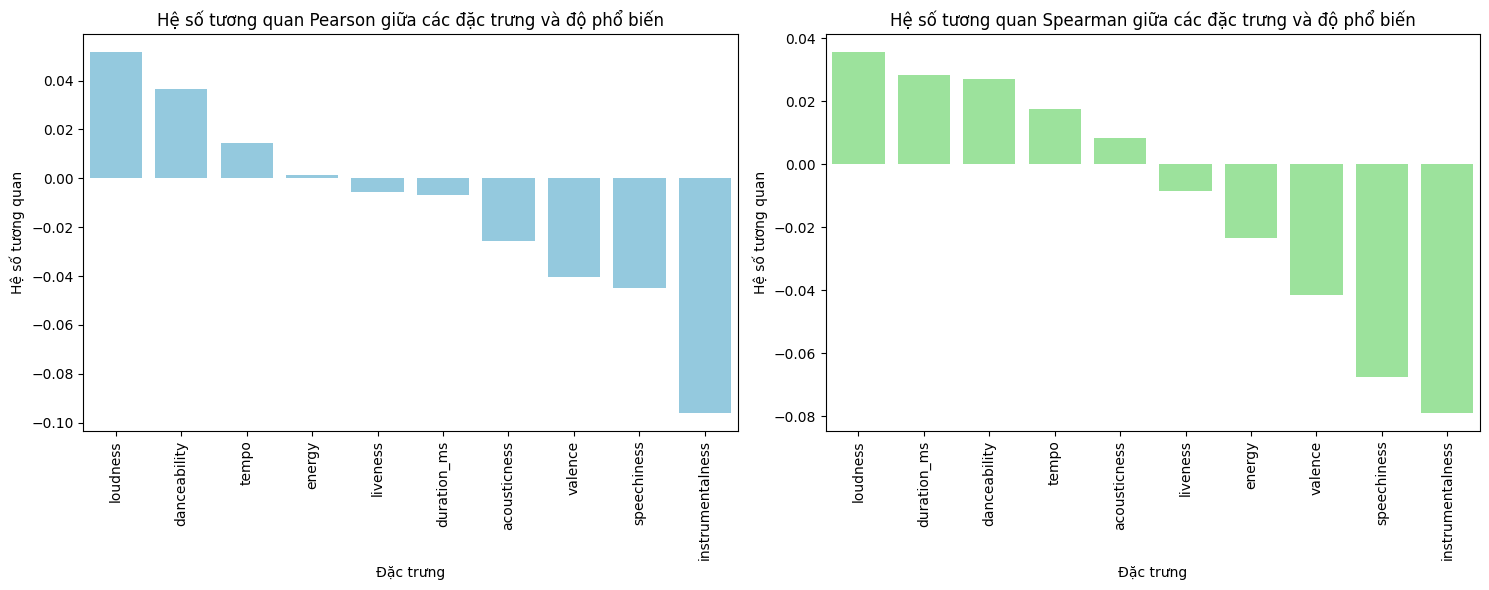

In [302]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.barplot(x=correlation_pearson.index, y=correlation_pearson.values, color='skyblue')
plt.title('Hệ số tương quan Pearson giữa các đặc trưng và độ phổ biến')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Đặc trưng')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.barplot(x=correlation_spearman.index, y=correlation_spearman.values, color='lightgreen')
plt.title('Hệ số tương quan Spearman giữa các đặc trưng và độ phổ biến')
plt.ylabel('Hệ số tương quan')
plt.xlabel('Đặc trưng')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

- Nhận xét tổng quan:
    - Hầu hết các hệ số tương quan đều cực kỳ gần 0.
    - Đặc trưng có độ lớn tuyệt đối của hệ số tương quan cao nhất là `instrumentalness` (~0.09). Các đặc trưng còn lại đều có độ lớn tuyệt đối loanh quanh 0.01-0.05.
    - Các đặc trưng âm thanh khi đứng một mình hầu như không có mỗi quan hệ tuyến tính hay đơn điều nào với độ phổ biến.
- Sự chênh lệch giữa hệ số tương quan Pearson và Spearman:
    - Không có mối quan hệ tuyến tính hay phi tuyến tính mạnh: Vì hệ số tương quan của Pearson và Spearman thấp như nhau. Do đó, dữ liệu có khả năng phân tán ngẫu nhiên so với biến `popularity`.
    - Dữ liệu khá ổn định về mặt phân phối: Ít có khả năng một bài hát ngoại lai làm sai sai lệch hoàn toàn kết quả, do Pearson và Spearman chênh lệch ít ở hầu hết các biến, cho thấy dữ liệu khá ổn định.
    - Tuy nhiên, `acousticness` và `energy` có sự đổi dấu hệ số tương quan giữa Pearson và Spearman. Điều này gợi ý rằng mối quan hệ giữa chúng và độ phổ biến không đồng nhất trên toàn bộ tập dữ liệu, và bị ảnh hưởng bởi các giá trị ngoại lai
- Các đặc trưng nổi bật:
    - `instrumentalness` và `speechiness`: Hai yếu tố có tương quan âm rõ rệt nhất. Nhạc không lời hoặc nhạc chứa quá nhiều từ ngữ thường khó đạt độ phổ biến cao.
    - `loudness` và `danceability`: Có tương quan dương nhất quán. Nhạc to, dễ nhảy dễ tiếp cận khán giả đại chúng hơn.

#### **Đặc trưng nhạc lý**

##### **Thống kê các đặc trưng**

In [303]:
feats_musical = feats_ordinal_musical + feats_binary_musical
for col in feats_musical:
    avg_popularity_by_col = df_copy.groupby(col)['popularity'].mean().sort_values(ascending=False)
    print("\n" + "="*10 + f"Độ phổ biến trung bình theo {col}" + "="*10)
    print(avg_popularity_by_col)


==========Độ phổ biến trung bình theo key==========
key
4     34.643936
2     34.370785
11    33.889464
6     33.579426
1     33.188681
3     33.030864
8     32.954805
5     32.930784
9     32.819589
7     32.582729
0     32.512113
10    32.431380
Name: popularity, dtype: float64

==========Độ phổ biến trung bình theo time_signature==========
time_signature
4    33.672807
3    29.692442
1    29.073998
5    28.778204
Name: popularity, dtype: float64

==========Độ phổ biến trung bình theo mode==========
mode
0    33.645762
1    32.999035
Name: popularity, dtype: float64


##### **Trực quang hóa giá trị trung bình**

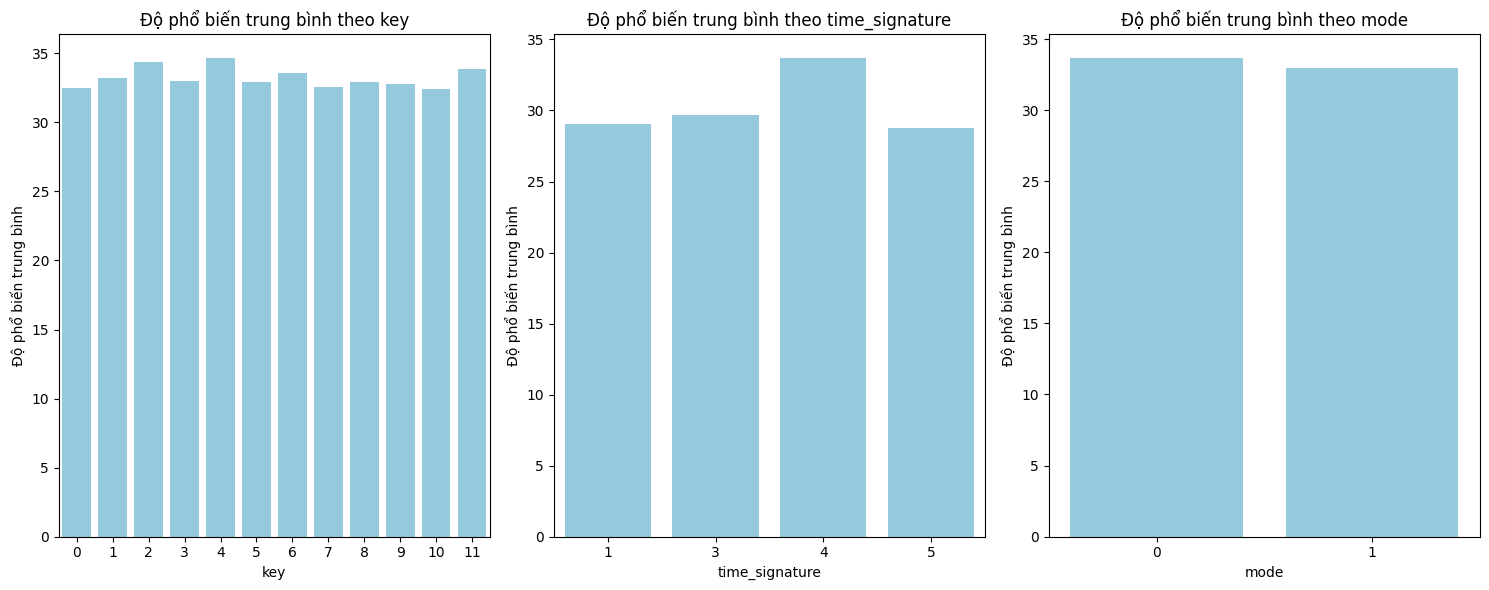

In [304]:
# Tính toán kích thước lưới biểu đồ
plots = len(feats_musical)
cols = 3  # Số biểu đồ trên 1 hàng
rows = math.ceil(plots / cols)  # Tự động tính số hàng cần thiết

# Vẽ biểu đồ
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows)) # Điều chỉnh kích thước tổng thể
axes = axes.flatten()

for i, col in enumerate(feats_musical):
    avg_popularity_by_col = df_copy.groupby(col)['popularity'].mean().reset_index()
    sns.barplot(data=df_copy, x=col, y=target_col, ax=axes[i], color='skyblue', errorbar=None)

    axes[i].set_title(f'Độ phổ biến trung bình theo {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Độ phổ biến trung bình')

# Ẩn các ô biểu đồ thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Độ phổ biến theo Key**
    - **Quan sát:** Chiều cao của các cột từ Key 0 đến Key 11 rất đồng đều, dao động nhẹ trong khoảng giá trị y từ 32 đến 35. Không có một Key nào nổi trội vượt bậc về độ phổ biến.
    - **Nhận xét:**
        - Biến thiên của độ phổ biến giữa các Key là rất thấp.
        - Key 2 và Key 4 có vẻ nhỉnh hơn một chút nhưng không đáng kể về mặt thống kê dựa trên trực quan.
    - **Key** của bài hát không phải là yếu tố quyết định đến việc bài hát đó có phổ biến hay không. Người nghe đại chúng không thiên vị cụ thể một tông nhạc nào.
- **Độ phổ biến theo time_signature**
    - **Quan sát:** Có sự chênh lệch rõ ràng hơn.
        - `time_signature = 4` có độ phổ biến trung bình cao nhất (đạt gần mức 34-35).
        - `time_signature = 3` đứng thứ hai (khoảng 30).
        - `time_signature = 1` và `5` có độ phổ biến thấp nhất (dưới 30).
    - **Nhận xét:**
        - Nhịp 4 là nhịp tiêu chuẩn và phổ biến nhất trong âm nhạc hiện đại, dễ nghe và dễ bắt tai, điều này lý giải cho chỉ số phổ biến cao nhất.
        - Nhịp 3 cũng khá phổ biến nhưng kén hơn nhịp 4.
        - Các nhịp phức tạp hoặc lạ (1, 5) thường khó tiếp cận đại chúng hơn, dẫn đến độ phổ biến trung bình thấp hơn.
    - **time_signature** là một đặc trưng có ý nghĩa để dự đoán độ phổ biến.
- **Độ phổ biến theo Mode**
    - **Quan sát:** Hai cột 0 và 1 có chiều cao gần như bằng nhau (xấp xỉ 33-34).
    - **Nhận xét:** Dù bài hát mang âm hưởng Trưởng (Major - thường vui tươi) hay Thứ (Minor - thường buồn bã), thì cơ hội để trở nên phổ biến là như nhau.
    - **mode** có tương quan rất yếu hoặc không có tương quan với độ phổ biến trung bình.

##### **Trực quan hóa độ phân tán của dữ liệu**

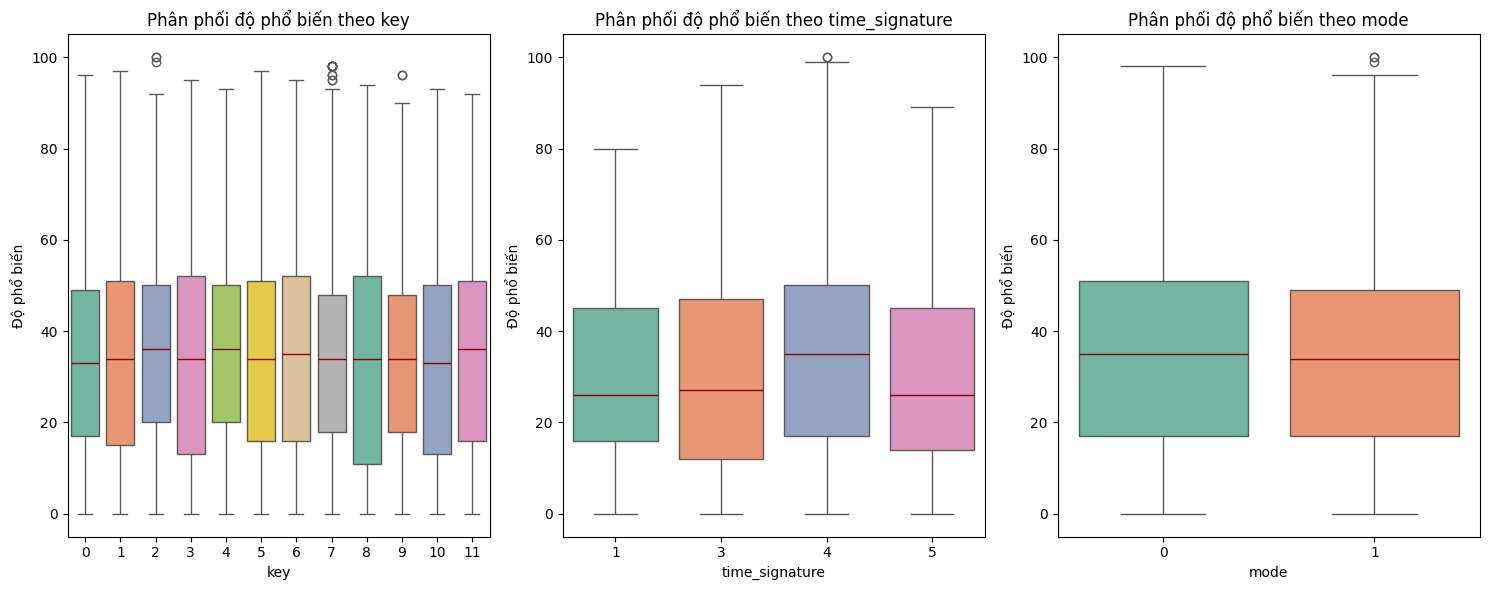

In [305]:
# Tính toán kích thước lưới biểu đồ
plots = len(feats_musical)
cols = 3  # Số biểu đồ trên 1 hàng
rows = math.ceil(plots / cols)  # Tự động tính số hàng cần thiết

# Vẽ biểu đồ
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows)) # Điều chỉnh kích thước tổng thể
axes = axes.flatten()

for i, col in enumerate(feats_musical):
    sns.boxplot(data=df_copy, x=col, y=target_col, ax=axes[i], hue=col, palette='Set2', legend=False, medianprops={'color': 'darkred'})

    axes[i].set_title(f'Phân phối độ phổ biến theo {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Độ phổ biến')

# Ẩn các ô biểu đồ thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Phân phối theo Key**
    - **Trung vị:** Khá ổn định giữa các Key, dao động quanh mức 35-40. Không có Key nào có trung vị vượt trội hẳn.
    - **Độ trải giữa (IQR):** Các hộp có chiều cao tương đương nhau, cho thấy mức độ biến động của độ phổ biến là như nhau ở mọi tông nhạc.
    - **Giá trị ngoại lai:** Xuất hiện các điểm tròn ở phía trên (mức 90-100) ở một số Key (như 2, 7, 9). Điều này chứng tỏ các bài hát cực kỳ phổ biến có thể xuất hiện ngẫu nhiên ở các Key này, nhưng là trường hợp hiếm chứ không phải xu hướng chung.

- **Phân phối theo time_signature**
    - **Sự khác biệt rõ rệt:** Đây là biểu đồ có thông tin giá trị nhất.
    - **Time_signature = 4:**
        - Có trung vị cao nhất (xấp xỉ 35-38).
        - Có Outlier đạt mức gần 100.
    - **Time_signature = 1, 3, 5:** Có phân phối lệch về phía thấp hơn (Median khoảng 25). Đặc biệt nhịp 3 có hộp khá thấp, cho thấy phần lớn các bài hát nhịp này khó đạt độ phổ biến cao.

- **Phân phối theo mode**
    - **Sự tương đồng:** Hai hộp biểu diễn Mode 0 và 1 gần như giống hệt nhau về cả Trung vị, IQR và khoảng biên.
    - **Kết luận:** **mode** hoàn toàn không phân tách được độ phổ biến. Dữ liệu này khẳng định lại nhận định ở biểu đồ cột trước đó: Âm hưởng vui/buồn không quyết định thành bại của bài hát.

#### **Đặc trưng thể loại nội dung**

##### **Đặc trưng Nominal**

Độ phổ biến trung bình của các thể loại hàng đầu và các ít được biết tới nhất.

In [306]:
avg_popularity_by_genre = df_copy.groupby('track_genre')['popularity'].mean().sort_values(ascending=False).reset_index()
print("="*10 + "Top 10 thể loại nhạc phổ biến nhất" + "="*10)
display(avg_popularity_by_genre.head(10))
print("\n" + "="*10 + "Top 10 thể loại nhạc ít phổ biến nhất" + "="*10)
display(avg_popularity_by_genre.tail(10))

==========Top 10 thể loại nhạc phổ biến nhất==========


,track_genre,popularity
0,pop-film,59.283000
1,k-pop,56.952953
2,chill,53.651000
3,sad,52.379000
4,grunge,49.594000
5,indian,49.539000
6,anime,48.772000
7,emo,48.128000
8,sertanejo,47.866000
9,pop,47.576000



==========Top 10 thể loại nhạc ít phổ biến nhất==========


,track_genre,popularity
104,idm,15.766000
105,kids,14.888000
106,grindcore,14.625000
107,jazz,13.579580
108,classical,13.055000
109,chicago-house,12.339000
110,detroit-techno,11.174000
111,latin,8.297000
112,romance,3.222222
113,iranian,2.218876


Trực quan hóa độ phổ biến trung bình của các nhóm thể loại (Chia theo xếp hạng độ phổ biến)

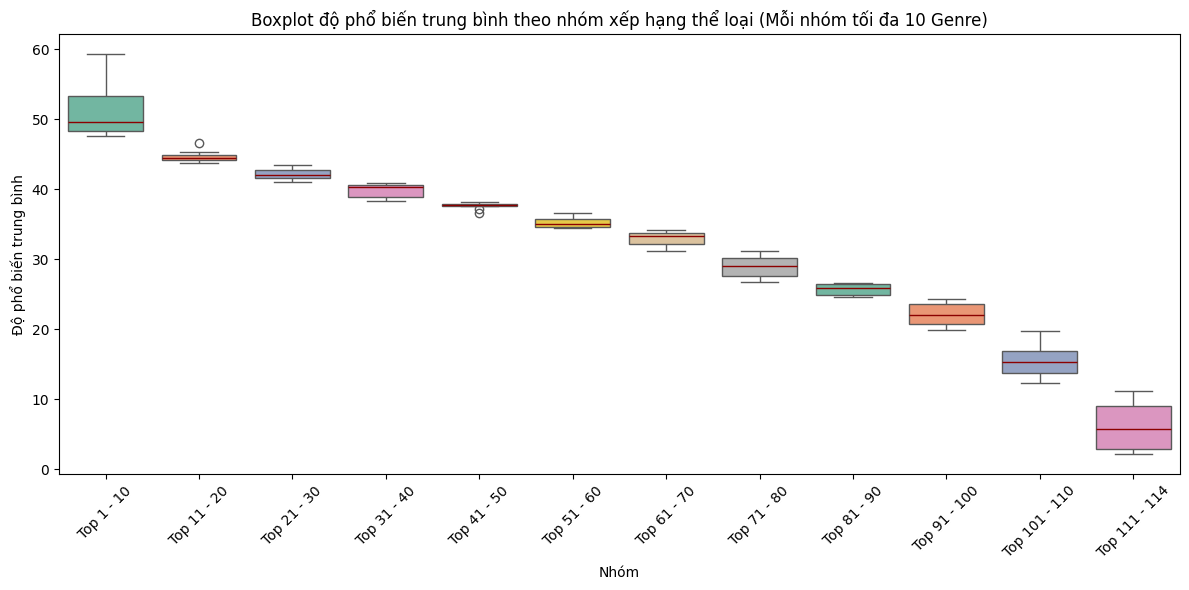

In [307]:
# Tạo dictionary ánh xạ từ genre sang nhóm
genre_to_group = {}
group_size = 10

for i, genre in enumerate(avg_popularity_by_genre['track_genre']):
    group_num = i // group_size + 1
    genre_to_group[genre] = f'Top {(group_num-1)*group_size + 1} - {min(len(avg_popularity_by_genre), (group_num)*group_size)}'

# Thêm cột nhóm
avg_popularity_by_genre['genre_group'] = avg_popularity_by_genre['track_genre'].map(genre_to_group)

# Sắp xếp các nhóm theo thứ tự top tăng dần
group_order = sorted(avg_popularity_by_genre['genre_group'].unique(), 
                     key=lambda x: int(x.split()[1]))

# Vẽ boxplot
plt.figure(figsize=(12, 6))

sns.boxplot(data=avg_popularity_by_genre, x='genre_group', y='popularity', order=group_order, hue='genre_group', palette='Set2', medianprops={'color': 'darkred'})
plt.title('Boxplot độ phổ biến trung bình theo nhóm xếp hạng thể loại (Mỗi nhóm tối đa 10 Genre)')
plt.xlabel('Nhóm')
plt.ylabel('Độ phổ biến trung bình')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- **Độ biến thiên:**
    - **Nhóm Top 1-10:** Có IQR khá rộng và whiskers dài. Điều này cho thấy ngay cả trong top 10 thể loại hot nhất, vẫn có sự chênh lệch lớn về độ phổ biến (từ khoảng 48 đến 60).
    - **Nhóm giữa (Top 31-60):** Các hộp rất dẹt (khoảng biến thiên hẹp). Điều này nghĩa là các thể loại trong phân khúc này có độ phổ biến rất đồng đều, ít sự khác biệt.
    - **Nhóm cuối (Top 101-114):** Hộp lại bắt đầu giãn ra và giá trị giảm mạnh về gần 0.
- **Giá trị ngoại lai (Outliers):**
    - Xuất hiện các điểm tròn nhỏ ở các nhóm như Top 11-20 và Top 41-50. Đây là các thể loại có độ phổ biến cao hoặc thấp bất thường so với nhóm của nó.

Trực quan hóa độ phổ biến trung bình cho nhóm phổ biến nhất (top 1-10) và nhóm ít phổ biến nhất (top 111-114)

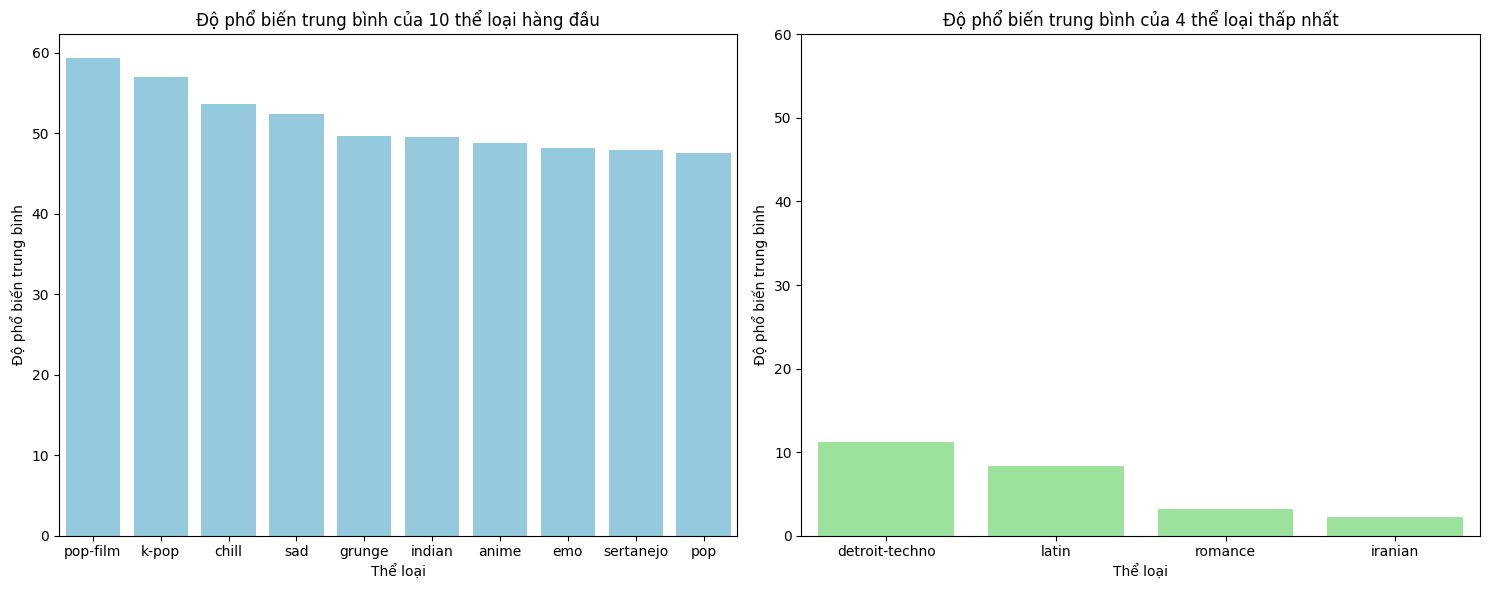

In [308]:
top_10 = avg_popularity_by_genre.head(10)
bottom_4 = avg_popularity_by_genre.tail(4)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
sns.barplot(x=top_10['track_genre'], y=top_10['popularity'], color='skyblue')
plt.title('Độ phổ biến trung bình của 10 thể loại hàng đầu')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel('Thể loại')

plt.subplot(1,2,2)
sns.barplot(x=bottom_4['track_genre'], y=bottom_4['popularity'], color='lightgreen')
plt.title('Độ phổ biến trung bình của 4 thể loại thấp nhất')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel('Thể loại')

plt.ylim(0, 60)
plt.tight_layout()
plt.show()

- **Nhóm Top 10:**
    - **Dải giá trị:** Rất cao và khá đồng đều, dao động từ khoảng 48 đến 60.
    - **Thứ hạng:** pop-film dẫn đầu (gần 60), theo sát là k-pop, chill, và sad.
    - **Đặc điểm:** Sự chênh lệch giữa vị trí số 1 (pop-film) và số 10 (pop) không quá lớn (khoảng 10-12 điểm).
- **Nhóm Bottom 4:**
    - **Dải giá trị:** Rất thấp, max chỉ khoảng 11 và min xuống gần 2.
    - **Thứ hạng:** detroit-techno (~11), latin (~8), romance (~3), iranian (~2).
    - **Đặc điểm:** Có sự sụt giảm nghiêm trọng. Ví dụ: detroit-techno cao gấp 5 lần iranian.
- **Nhận xét:** Nhìn chung xu hướng "Mood & Context" lên ngôi.
    - **Pop-film đứng đầu:** Điều này cho thấy người dùng có xu hướng nghe nhạc gắn liền với ngữ cảnh hoặc thương hiệu phim ảnh. Nhạc phim thường có độ viral cao nhờ hiệu ứng từ phim.
    - **Sự trỗi dậy của "Mood Music":** Các thể loại chill, sad thực chất là trạng thái cảm xúc hơn là thể loại nhạc thuần túy về kỹ thuật. Việc chúng nằm trong Top 5 cho thấy người dùng ngày nay tìm kiếm nhạc để phục vụ cảm xúc hoặc làm nền cho hoạt động nhiều hơn là tìm kiếm theo dòng nhạc cụ thể.

##### **Đặc trưng Binary**

Thống kê

In [309]:
avg_popularity_by_col = df.groupby(feats_binary_metadata)['popularity'].mean().sort_values(ascending=False)
print("\n" + "="*10 + f"Độ phổ biến trung bình theo {feats_binary_metadata}" + "="*10)
print(avg_popularity_by_col)


==========Độ phổ biến trung bình theo explicit==========
explicit
True     36.454191
False    32.937891
Name: popularity, dtype: float64


Trực quan hóa độ phổ biến trung bình

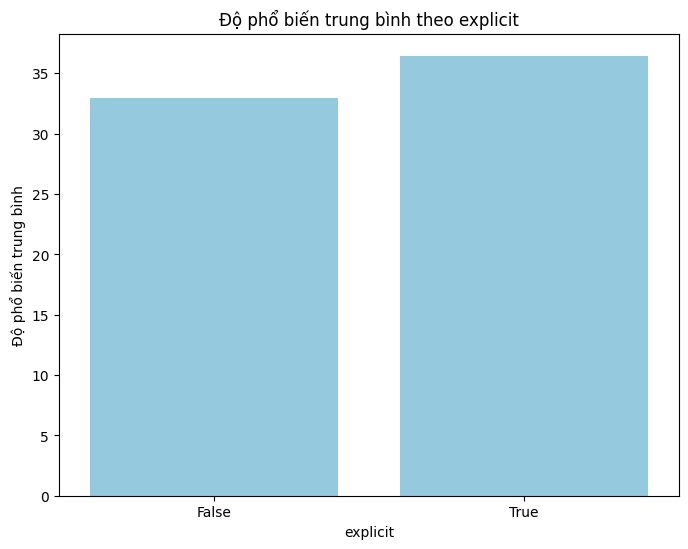

In [310]:
# Vẽ barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_popularity_by_col.index, y=avg_popularity_by_col.values, color='skyblue')
plt.title(f'Độ phổ biến trung bình theo {feats_binary_metadata}')
plt.ylabel('Độ phổ biến trung bình')
plt.xlabel(feats_binary_metadata)
plt.show()

- **Sự chênh lệch:** Có sự khác biệt về độ phổ biến trung bình giữa hai nhóm. Các bài hát/nội dung được dán nhãn `explicit=True` có độ phổ biến cao hơn so với nhóm `explicit=False`.
- **Độ lớn:** Mức chênh lệch rơi vào khoảng 3-4 điểm. Đây không phải là mức chênh lệch quá lớn.
- Có thể các thể loại nhạc thịnh hành hiện nay thường chứa nhiều nội dung nhạy cảm. Chính thể loại nhạc mới là yếu tố kéo độ phổ biến lên, còn nội dung nhạy cảm chỉ là đặc tính đi kèm của thể loại đó.

Trực quan phân phối của độ phổ biến

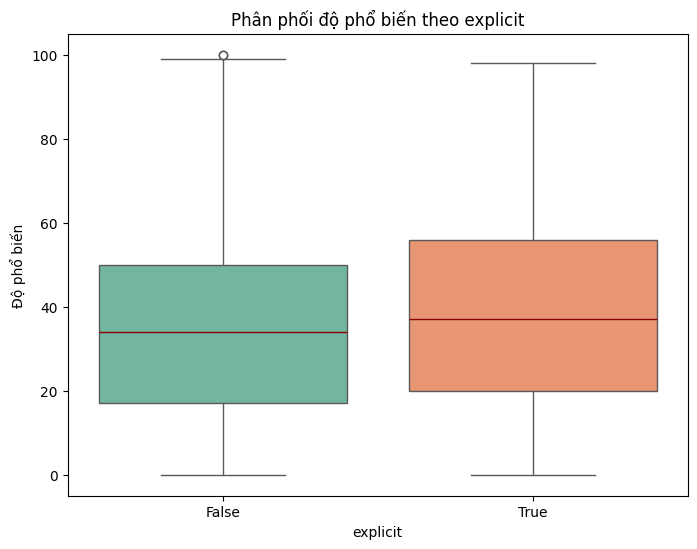

In [311]:
# Vẽ boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_copy, x=feats_binary_metadata, y='popularity', hue=feats_binary_metadata, palette='Set2', medianprops={'color': 'darkred'}, legend=False)
plt.title(f'Phân phối độ phổ biến theo {feats_binary_metadata}')
plt.xlabel(feats_binary_metadata)
plt.ylabel('Độ phổ biến')
plt.show()

- **Trung vị cao hơn:** Đường màu đỏ của nhóm True nằm cao hơn nhóm False. Điều này khẳng định lại nhận định ở biểu đồ trước: Nhạc có nội dung nhạy cảm có xu hướng phổ biến hơn, ngay cả khi loại bỏ ảnh hưởng của các giá trị cực đoan.
- **Độ phân tán:** Cả hai nhóm đều có độ phân tán rất rộng (từ 0 đến gần 100). Điều này cho thấy tính chất explicit không đảm bảo một bài hát sẽ thành hit, nó chỉ nhích nhẹ khả năng đó lên thôi.
- **Vùng tập trung dữ liệu:** Hộp màu cam (True) nằm cao hơn hộp màu xanh (False) một chút. 50% số bài hát explicit nằm trong khoảng điểm 20-55, trong khi 50% bài hát không explicit nằm trong khoảng 18-50.
- Một bài hát dán nhãn Explicit có xác suất bị rơi vào nhóm kém phổ biến thấp hơn một chút so với bài hát thường. Có thể hiểu là nội dung Explicit có một lượng khán giả trung thành giúp giữ nhiệt cho bài hát tốt hơn là các bài nhạc thường nhưng nhạt nhòa.

### **5.2. So sánh mỗi quan hệ giữa nhóm Hit (Popularity > 75) và Non-Hit (Popularity < 25) về các đặc trưng âm thanh**

#### **Xác định các bài hát Hit và Non-Hit**

In [312]:
df_hit = df_copy[df_copy['popularity'] > 75]
df_non_hit = df_copy[df_copy['popularity'] < 25]

print(f"Số lượng bài hát Hit: {df_hit.shape[0]} | Tỷ lệ: {df_hit.shape[0]/df_copy.shape[0]:.2%}")

print(f"Số lượng bài hát Non-Hit: {df_non_hit.shape[0]} | Tỷ lệ: {df_non_hit.shape[0]/df_copy.shape[0]:.2%}")

Số lượng bài hát Hit: 2412 | Tỷ lệ: 2.12%
Số lượng bài hát Non-Hit: 42806 | Tỷ lệ: 37.60%


#### **Trực quan hóa**

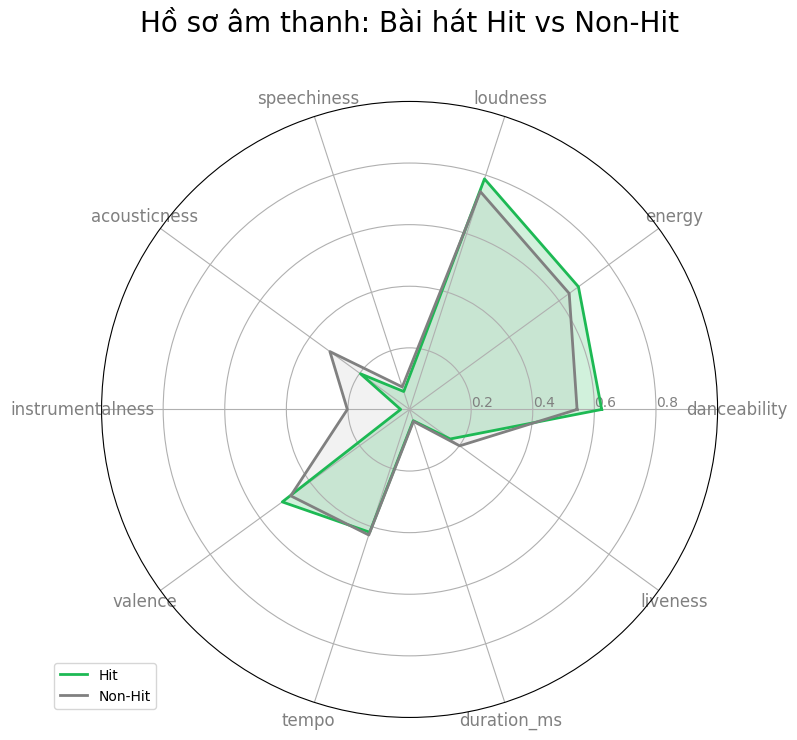

In [313]:
num_feat = len(feats_audio)

# Tính góc cho mỗi trục (chia tròn 360 độ thành N phần)
angles = [n / float(num_feat) * 2 * pi for n in range(num_feat)]
angles += angles[:1] # Đóng vòng tròn lại (nối điểm cuối về điểm đầu)

# Khởi tạo biểu đồ Polar
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Vẽ trục cho mỗi biến
plt.xticks(angles[:-1], feats_audio, color='grey', size=12)

# Vẽ trục y (các vòng tròn đồng tâm)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, 1) # Giới hạn giá trị từ 0 đến 1

# --- Vẽ nhóm HIT ---
values_hit = df_hit[feats_audio].mean().values.tolist()
values_hit += values_hit[:1] # Đóng vòng tròn
ax.plot(angles, values_hit, linewidth=2, linestyle='solid', label='Hit', color='#1DB954') # Màu xanh Spotify
ax.fill(angles, values_hit, '#1DB954', alpha=0.2) # Tô màu

# --- Vẽ nhóm NON-HIT ---
values_non_hit = df_non_hit[feats_audio].mean().values.tolist()
values_non_hit += values_non_hit[:1] # Đóng vòng tròn
ax.plot(angles, values_non_hit, linewidth=2, linestyle='solid', label='Non-Hit', color='gray')
ax.fill(angles, values_non_hit, 'gray', alpha=0.1)

# Trang trí
plt.title('Hồ sơ âm thanh: Bài hát Hit vs Non-Hit', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()



- **Nhóm tính chất vượt trội ở bài hát Hit:**
    - **Danceability:** Đây là đặc trưng phân loại rõ rệt nhất. Đường màu xanh vươn ra xa hơn hẳn so với đường màu xám. Điều này cho thấy các bài hát Hit thường có tiết tấu dễ nhảy, bắt tai hơn.
    - **Energy và Loudness:** Cả hai nhóm đều có chỉ số này cao, nhưng nhóm Hit nhỉnh hơn một chút. Nhạc Hit thường sôi động và to, rõ ràng.
- **Nhóm tính chất vượt trội ở bài hát Non-Hit:**
    - **Acousticness và Instrumentalness:** Nhóm Non-Hit vươn ra xa hơn hẳn ở hai trục này, trong khi nhóm Hit co cụm về gần tâm. Điều này cho thấy nhạc không lời hoặc nhạc quá mộc mạc khó trở thành Hit đại chúng hơn.
- **Nhóm tính chất tương đồng hoặc thấp:**
    - **Liveness và Speechiness:** Cả hai nhóm đều có chỉ số thấp. Điều này dễ hiểu vì nhạc studio (ít tạp âm khán giả) và nhạc có giai điệu (ít đọc/nói) là tiêu chuẩn chung của âm nhạc thương mại.
    - **Valence và Tempo:** Hai nhóm khá tương đồng, giao nhau nhiều, cho thấy bài hát buồn hay vui và nhịp độ như thế nào không phải là yếu tố quyết định duy nhất để thành Hit.

## **6. Trả lời câu hỏi và kết luận**

Dựa trên quá trình phân tích dữ liệu, chúng tôi đúc kết được "Công thức bài Hit" trên Spotify không phụ thuộc vào một yếu tố duy nhất mà là sự tổng hòa của các thành phần sau:
1. **Chọn đúng thể loại nhạc**
    - Đây là yếu tố có trọng số lớn nhất. Dữ liệu cho thấy sự phân hóa cực lớn về độ phổ biến trung bình giữa các dòng nhạc.
    - **Công thức:** Để dễ thành Hit, bài hát nên thuộc các thể loại đại chúng như Pop-film, K-pop, Chill, Sad,...
    - **Tránh:** Các thể loại ngách như Iranian, Latin, Romance, Detroit-techno có xác suất thành công cực thấp bất kể chất lượng âm thanh.
2. **Những bài nhạc sôi động**
    - Biểu đồ Radar so sánh giữa nhóm Hit và Non-Hit đã chỉ ra hồ sơ âm thanh đặc trưng của một bài Hit:
        - **Năng lượng:** Phải cao. Khán giả đại chúng ưu chuộng các bài hát mang lại cảm giác mạnh mẽ, kích thích.
        - **Khả năng nhún nhảy:** Phải cao. Bài hát cần có tiết tấu rõ ràng, to và dễ bắt nhịp để phù hợp với xu hướng nghe nhạc hiện đại.
3. **Sản xuất hiện đại**
    - Xu hướng thị trường loại bỏ các yếu tố quá mộc mạc hoặc hàn lâm:
        - **Acousticness và Instrumentalness:** Các bài Hit có chỉ số này cực thấp. Điều này cho thấy âm nhạc điện tử, được xử lý kỹ thuật số và có lời hát dễ tiếp cận khán giả hơn là nhạc mộc hoặc nhạc không lời.
4. **Những yếu tố "Không quan trọng"**
    - Dữ liệu cũng giúp bác bỏ những niềm tin sai lầm về nhạc lý:
        - Key & Mode: Việc bài hát viết ở giọng Trưởng hay Thứ, hay chọn tông C (Đô) hay G (Sol) hoàn toàn không ảnh hưởng đến độ phổ biến. Khán giả quan tâm đến giai điệu hơn là cấu trúc nhạc lý.
5. **Tóm tắt Công thức:**
- HIT = (Thể loại Pop/Kpop) + (Energy cao + Danceability cao) + (Sản xuất điện tử/Có lời) + (Thời lượng tiêu chuẩn 2-5 phút)

# **Câu 2: Liệu chúng ta có thể xây dựng mô hình Machine Learning để dự đoán chính xác độ phổ biến của một bài hát dựa trên các đặc trưng âm thanh và thể loại không?**

## **1. Động lực**

- Giúp các nghệ sĩ và nhà sản xuất ước lượng tiềm năng thành công của bài hát trước khi phát hành.
- **Tối ưu hóa ngân sách marketing:** Tập trung quảng bá cho các bài hát được mô hình dự đoán điểm cao.
- **Hiểu rõ trọng số:** Mô hình sẽ cho biết chính xác yếu tố nào đóng góp bao nhiêu % vào thành công.

## **2. Quy trình thực hiện**

### **Tiền xử lý dữ liệu**

In [314]:
# Sao chép dataframe
df_copy = df.copy()

#### **Xác định các đặc trưng dùng để huấn luyện mô hình**

In [315]:
# Chọn các đặc trưng âm thanh, thể loại và mục tiêu
feats_audio = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "duration_ms", "liveness"]
feats_metadata = ["track_genre", "explicit"]
target_col = "popularity"

data_ml = df_copy[feats_audio + feats_metadata + [target_col]].copy()

#### **Mã hóa các đặc trưng cần thiết**

In [316]:
# Mã hóa đặc trưng track_genre bằng Label Encoding
le = LabelEncoder()
data_ml['track_genre'] = le.fit_transform(data_ml['track_genre'])

# Mã hóa đặc trưng explicit thành 0 và 1
data_ml['explicit'] = data_ml['explicit'].astype(int)

#### **Chia tập dữ liệu để huấn luyện mô hình**

- Chia 80% dữ liệu để huấn luyện, đánh giá mô hình trước và 20% dữ liệu để kiểm tra

In [317]:
X_train_val, X_test, y_train_val, y_test = train_test_split(data_ml[feats_audio + feats_metadata], data_ml[target_col], test_size=0.2, random_state=42)

#### **Chuẩn hóa dữ liệu**

- **StandardScaler** sẽ đưa dữ liệu về phân phối chuẩn. Nó ít bị ảnh hưởng bởi outlier hơn và giữ được khoảng cách phân phối tốt hơn.

In [318]:
# Xử lý các đặc trưng bằng StandardScaler
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

### **Lựa chọn mô hình**

- **Linear Regression:**
    - **Vai trò:** Làm mô hình cơ sở.
    - **Dự đoán:** Vì ở Câu 1 ta thấy tương quan tuyến tính rất thấp, nên khả năng cao mô hình này sẽ hoạt động kém. Nhưng bạn vẫn cần làm để chứng minh rằng mối quan hệ này là phi tuyến.
- **Random Forest Regressor:**
    - **Vai trò:** Mô hình chính.
    - **Ưu điểm:** Xử lý cực tốt các mối quan hệ phi tuyến và tương tác phức tạp.
    - **Dự đoán:** Sẽ cho kết quả tốt hơn nhiều.

### **Chiến lược huấn luyện mô hình**

- **Bước 1:** Cắt riêng 20% dữ liệu làm tập Test.
- **Bước 2:** Với 80% dữ liệu còn lại, sử dụng kỹ thuật 10-Fold Cross-Validation.
    - Máy sẽ tự động chia 80% này thành 10 phần.
        - Lần 1: Học 9 phần, thi 1 phần. Ra điểm số 1.
        - Lần 2: Học 9 phần khác, thi 1 phần khác. Ra điểm số 2.
        - ...
        - Lần 10: Học 9 phần khác, thi 1 phần khác. Ra điểm số 10.
    - **Kết quả:** Trung bình của 10 lần huấn luyện. Đây chính là điểm số đại diện cho khả năng của mô hình.
- **Bước 3:** Huấn luyện 2 mô hình trên toàn bộ 80% dữ liệu và kiểm tra lần cuối trên tập Test 20%

In [319]:
# Xác định K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Định nghĩa các metric đánh giá
scoring_metrics = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}

#### **Mô hình hồi quy tuyến tính**

In [320]:
# Đánh giá mô hình hồi quy tuyến tính
lin_reg = LinearRegression()

# Cross-Validation với 10 folds
cv_results_lin = cross_validate(lin_reg, X_train_val_scaled, y_train_val, 
                                cv=kf, scoring=scoring_metrics)

# Tính toán và in kết quả trung bình
lin_r2_scores = cv_results_lin['test_R2']
lin_rmse_scores = -cv_results_lin['test_RMSE']

print("="*10 + f"Linear Regression (10-Fold CV)" + "="*10)
print(f"R2 Trung bình:   {lin_r2_scores.mean():.4f} (+/- {lin_r2_scores.std():.4f})")
print(f"RMSE Trung bình: {lin_rmse_scores.mean():.4f} (+/- {lin_rmse_scores.std():.4f})")

# Huấn luyện mô hình trên toàn bộ tập huấn luyện và đánh giá trên tập test
lin_reg.fit(X_train_val_scaled, y_train_val)
y_pred_lin = lin_reg.predict(X_test_scaled)

test_r2_lin = r2_score(y_test, y_pred_lin)
test_rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print("="*10 + f"Kết quả trên tập Test" + "="*10)
print(f"R2 :   {test_r2_lin:.4f}")
print(f"RMSE : {test_rmse_lin:.4f}")

==========Linear Regression (10-Fold CV)==========
R2 Trung bình:   0.0251 (+/- 0.0036)
RMSE Trung bình: 22.0441 (+/- 0.0910)
==========Kết quả trên tập Test==========
R2 :   0.0231
RMSE : 21.9566


In [321]:
# Đánh giá mô hình Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-Validation với 10 folds
cv_results_rf = cross_validate(rf_reg, X_train_val_scaled, y_train_val, 
                               cv=kf, scoring=scoring_metrics)

# Tính toán và in kết quả trung bình
rf_r2_scores = cv_results_rf['test_R2']
rf_rmse_scores = -cv_results_rf['test_RMSE']

print("="*10 + f"Random Forest Regressor (10-Fold CV)" + "="*10)
print(f"R2 Trung bình:   {rf_r2_scores.mean():.4f} (+/- {lin_r2_scores.std():.4f})")
print(f"RMSE Trung bình: {rf_rmse_scores.mean():.4f} (+/- {lin_rmse_scores.std():.4f})")

# Huấn luyện mô hình trên toàn bộ tập huấn luyện và đánh giá trên tập test
rf_reg.fit(X_train_val_scaled, y_train_val)
y_pred_rf = rf_reg.predict(X_test_scaled)

test_r2_rf = r2_score(y_test, y_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("="*10 + f"Kết quả trên tập Test" + "="*10)
print(f"R2 :   {test_r2_rf:.4f}")
print(f"RMSE : {test_rmse_rf:.4f}")

==========Random Forest Regressor (10-Fold CV)==========
R2 Trung bình:   0.5072 (+/- 0.0036)
RMSE Trung bình: 15.6719 (+/- 0.0910)
==========Kết quả trên tập Test==========
R2 :   0.5191
RMSE : 15.4056


### **Trực quan hóa và đánh giá**

#### **Trực quan hóa độ phù hợp và sai số tuyệt đối của hai mô hình**

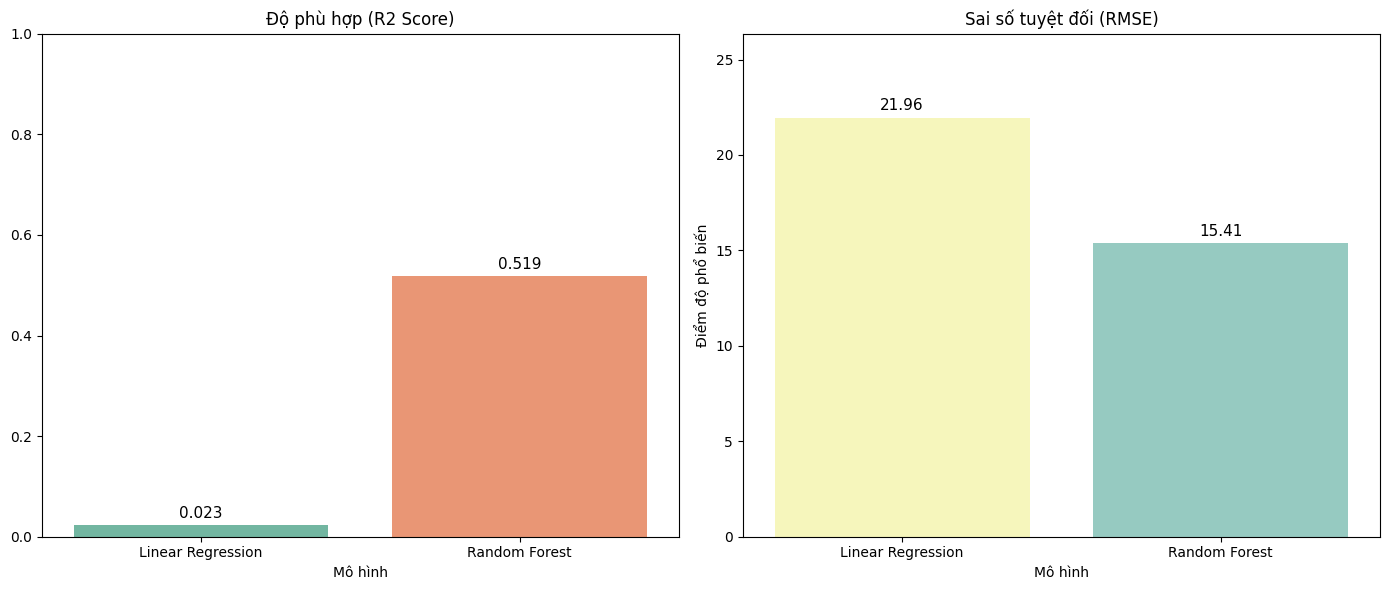

In [322]:
model_names = ['Linear Regression', 'Random Forest']
r2_scores = [test_r2_lin, test_r2_rf]
rmse_scores = [test_rmse_lin, test_rmse_rf]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R2 Scores
sns.barplot(x=model_names, y=r2_scores, ax=axes[0], palette='Set2', hue=r2_scores, legend=False)
axes[0].set_title('Độ phù hợp (R2 Score)')
axes[0].set_xlabel('Mô hình')
axes[0].set_ylim(0, 1)
for i in axes[0].containers:
    axes[0].bar_label(i, fmt='%.3f', padding=3, fontsize=11)

# RMSE Scores
sns.barplot(x=model_names, y=rmse_scores, ax=axes[1], palette='Set3', hue=rmse_scores, legend=False)
axes[1].set_title('Sai số tuyệt đối (RMSE)')
axes[1].set_xlabel('Mô hình')
axes[1].set_ylabel('Điểm độ phổ biến')

axes[1].set_ylim(0, max(rmse_scores) * 1.2)

for i in axes[1].containers:
    axes[1].bar_label(i, fmt='%.2f', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

- **Độ phù hợp ($R^2$ Score)**
    - **Linear Regression:** Đạt $R^2 = 0.023$. Đây là một kết quả cực kỳ thấp. Giá trị gần 0 cho thấy mô hình tuyến tính gần như không học được bất kỳ quy luật nào từ dữ liệu, nó hoạt động chỉ nhỉnh hơn một chút so với việc đoán giá trị trung bình của tập dữ liệu.
    - **Random Forest:** Đạt $R^2 = 0.519$. Kết quả này tốt hơn vượt trội so với Linear Regression. Nó cho thấy mô hình giải thích được khoảng 51.8% sự biến thiên của dữ liệu. Tuy chưa phải là mức xuất sắc (thường mong đợi > 0.7 hoặc 0.8), nhưng nó cho thấy mô hình đã bắt được các mẫu nhất định.
- **Sai số tuyệt đối (RMSE)**
    - Linear Regression: RMSE = 21.96. Sai số trung bình của dự đoán lệch khoảng 22 đơn vị so với thực tế.
    - Random Forest: RMSE = 15.41. Sai số giảm đáng kể (khoảng 30%) so với Linear Regression. Điều này đồng nhất với kết quả $R^2$ ở trên.
- **Nhận xét:**
    - Dữ liệu có tính Phi tuyến: Sự thất bại hoàn toàn của Linear Regression ($R^2 \approx 0$) và sự cải thiện rõ rệt của Random Forest chứng tỏ mối quan hệ giữa các đặc trưng đầu vào và biến mục tiêu không phải là quan hệ tuyến tính.
    -  Vẫn còn nhiều dữ liệu nhiễu hoặc thiếu các đặc trưng quan trọng. Mặc dù Random Forest tốt hơn, nhưng $R^2 = 0.519$ nghĩa là vẫn còn 48.2% phương sai của dữ liệu chưa được giải thích.

#### **Trực quan hóa mức độ quan trọng của các đặc trưng**

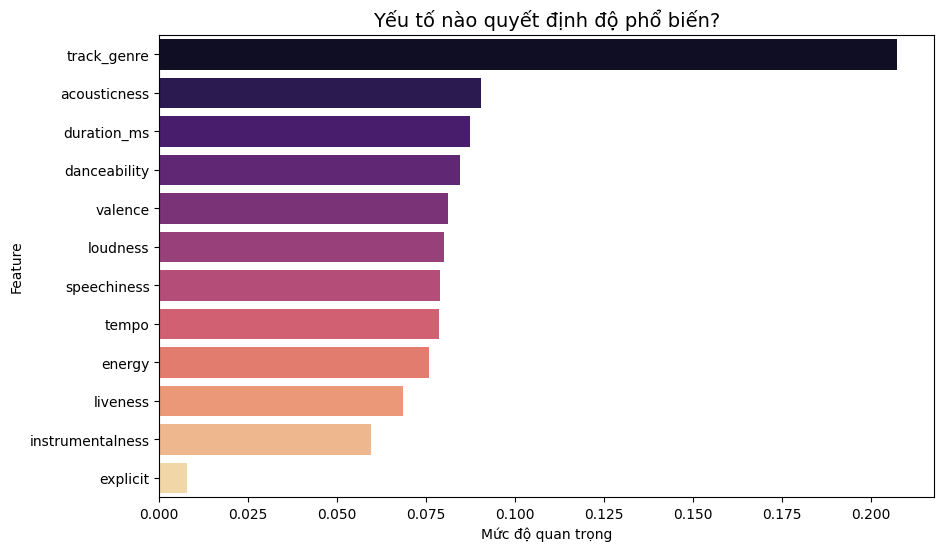

In [323]:
# Lấy feature importance từ mô hình Random Forest đã train
importances = rf_reg.feature_importances_

# Tạo DataFrame các đặc trưng và mức độ quan trọng
feature_imp_df = pd.DataFrame({
    'Feature': feats_audio + feats_metadata,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='magma', hue=feature_imp_df['Feature'], legend=False)
plt.title('Yếu tố nào quyết định độ phổ biến?', fontsize=14)
plt.xlabel('Mức độ quan trọng')
plt.show()

- **Đặc trưng ảnh hướng nhất (track_genre):** Đây là yếu tố áp đảo nhất (gần 0.21). Điều này có nghĩa là thể loại nhạc là yếu tố quyết định hàng đầu xem bài hát có phổ biến hay không. Điều này rất hợp lý về mặt nghiệp vụ vì một bài hát thuộc thể loại "Pop" hay "K-pop" thường có xác suất phổ biến cao hơn hẳn so với "romance" hay "iranian".
- **Nhóm ảnh hưởng trung bình cao (acousticness, duration_ms, danceability):** Các yếu tố này đóng góp khoảng 0.08 - 0.09. Điều này cho thấy tính chất vật lý của âm thanh và độ dài bài hát là những bộ lọc quan trọng tiếp theo.
- **Nhóm bão hòa (valence, loudness, speechiness, tempo, energy):** Có mức độ quan trọng sàn sàn nhau (quanh mốc 0.075).
- **Yếu tố ít quan trọng nhất (explicit):** Việc bài hát có chứa nội dung nhạy cảm hay không gần như không ảnh hưởng đến độ phổ biến trong mô hình này (chỉ số rất thấp, nhỏ hơn 0.02).

#### **Trực quan hóa độ phổ biển thực tế và dự đoán của mô hình Random Forest**

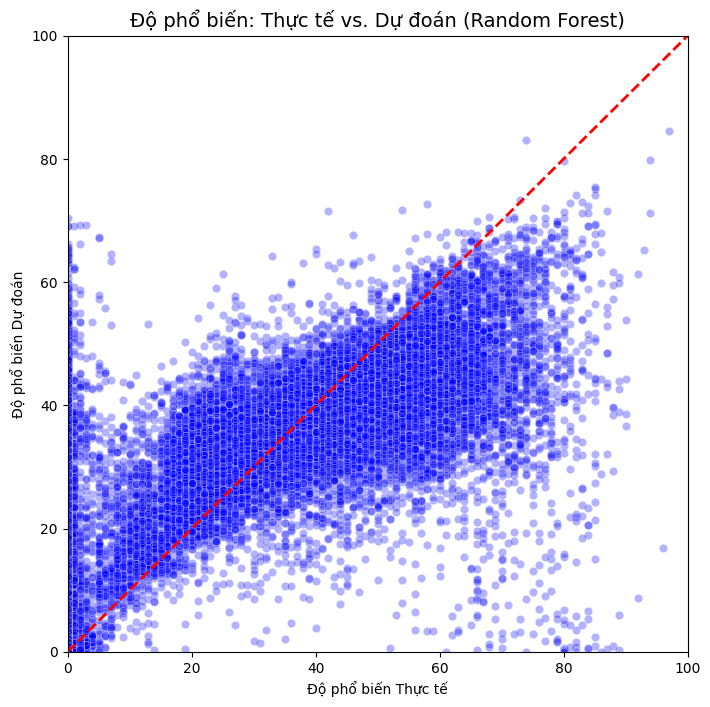

In [324]:
# Dự đoán trên tập Test
y_pred_rf = rf_reg.predict(X_test_scaled)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='blue')

# Vẽ đường chéo đỏ (Đường hoàn hảo y=x)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', linewidth=2)

plt.title('Độ phổ biến: Thực tế vs. Dự đoán (Random Forest)', fontsize=14)
plt.xlabel('Độ phổ biến Thực tế')
plt.ylabel('Độ phổ biến Dự đoán')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

- **Ảo tưởng tại điểm 0**:
    - Mô hình đang dự đoán những bài hát có độ phổ biến thực thế là 0 thì có độ phổ biến từ 20 đến 60, thậm chí có điểm lên tới 70.
    - Mô hình đang bị đánh giá quá cao đối với các bài hát không phổ biến. Điều này chứng tỏ: Các bài hát này có chất lượng âm thanh, thể loại giống hệt các bài hát nổi tiếng, nhưng thực tế chúng không ai nghe.
    - **Nguyên nhân tiềm ẩn:** Một bài hát hay nhưng do ca sĩ vô danh hát thì độ phổ biến vẫn là 0. Mô hình hiện tại chỉ nghe nhạc chứ không biết ai hát.

- **Không thể bắt được "Hit":**
    - Ở độ phổ biến thực tế lớn hơn 80, các điểm dữ liệu hầu hết nằm dưới đường.
    - Mô hình hiếm khi dự đoán bài nào trên 80 điểm. Nó có xu hướng kéo các giá trị cực đại về trung bình. Điều này thường thấy ở Random Forest khi nó không thể ngoại suy tốt ở các vùng biên dữ liệu cực đoan.

## **3. Kết luận về khả năng dự đoán**

- **Mô hình tuyến tính vô hiệu:** Các đặc trưng âm thanh không tác động đơn lẻ lên độ phổ biến.
- **Mô hình Random Forest khả quan ($R^2 \approx 0.52$):** Chúng ta có thể dự đoán độ phổ biến với độ chính xác trung bình khá dựa trên thông số kỹ thuật.
- **Tại sao không cao hơn?**
    - Con số 0.518 cho thấy dữ liệu hiện tại chỉ giải thích được một nửa sự thật. Một nửa còn lại của "Sự nổi tiếng" đến từ các yếu tố ngoài dữ liệu mà chúng ta không có, ví dụ:
        - Ngân sách Marketing/Quảng cáo.
        - Độ nổi tiếng sẵn có của Ca sĩ.
        - Thời điểm phát hành.
        - Sức mạnh của mạng xã hội.